# Introduction to Generative Modeling

In supervised learning, such as regression or classification, deep neural networks are mostly utilised. Nevertheless, Generative Adversarial Networks, or GANs, employ neural networks for a completely distinct function: Modelling in generative style

Using automatic discovery and learning of regularities or patterns in input data, generative modelling is an unsupervised machine learning task that aims to teach the model to produce or generate new examples that could have been reasonably taken from the original dataset. The Source


Visit thispersondoesnotexist.com to get an idea of the potential of generative models. A fresh representation of an individual's face is created on the spot each time the page is reloaded. The findings are very intriguing:
<img src="https://imgix.bustle.com/inverse/4b/17/8f/0e/cf91/4506/99c7/e6a491c5d4ac/these-people-are-not-real--they-were-produced-by-our-generator-that-allows-control-over-different-a.png" style="width:480px; margin-bottom:32px"/>

While there are many approaches used for generative modeling, a Generative Adversarial Network takes the following approach:

<img src="https://i.imgur.com/6NMdO9u.png" style="width:420px; margin-bottom:32px"/>

*Generator* and *Discriminator* are the two neural networks that are present. The discriminator looks for patterns in the data to determine if a sample is "real" (taken from the training set) or "fake" (produced by the generator). The generator creates a "fake" sample given a random vector or matrix. Training takes place in parallel: we train the generator for a few epochs after training the discriminator for a few epochs, and then we repeat. Both the discriminator and the generator improve at what they do as a result.

However, GANs are very sensitive to hyperparameters, activation functions, and regularisation, and can be notoriously hard to train. This article will show you how to train a GAN to produce faces of anime characters.


<img src="https://i.imgur.com/NaKtJs0.png" width="360" style="margin-bottom:32px"/>


The Anime Face Dataset, which has more than 63,000 cropped anime faces, will be used. Keep in mind that since generative modelling is an unsupervised learning job, there are no labels on the photos. This notebook is the source of most of the code in this tutorial.

In [53]:
project_name = '06b-anime-dcgan'

## Downloading and Exploring the Data

The [dataset](https://www.kaggle.com/splcher/animefacedataset) can be downloaded from Kaggle using the [{opendatasets}](https://github.com/JovianML/opendatasets) library. `opendatasets` downloads datasets from Kaggle using the [Kaggle Official API](https://github.com/Kaggle/kaggle-api).  To locate your API credentials, take the following actions:

1. Log in to [https://kaggle.com/](https://kaggle.com), then, from the menu, select "My Account" by clicking on your profile image in the upper right corner.

2. Click "Create New API Token" after swiping down to the "API" area. This will download `kaggle.json`, a file containing the following data:


```
{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
```

3. You will be prompted to provide your username and the Kaggle API when you run `opendatsets.download}. These may be found in the file you downloaded in step 2.

Keep in mind that downloading the {kaggle.json} file is only necessary once. You can alternatively use the files tab on Google Colab to submit the `kaggle.json` file, in which case the credentials will be automatically read.



In [54]:
!pip install opendatasets --upgrade --quiet

In [55]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


All 63,000+ JPG-formatted photos in the dataset are housed in a single folder named "images."

In [56]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [57]:
print(os.listdir(DATA_DIR+'/images')[:10])

['19718_2007.jpg', '14906_2006.jpg', '57380_2017.jpg', '9046_2004.jpg', '30064_2010.jpg', '2991_2002.jpg', '62211_2019.jpg', '35145_2011.jpg', '4423_2003.jpg', '44717_2013.jpg']


Now let's use the `ImageFolder` class from `torchvision` to load this dataset. In addition, we'll crop and resize the pictures to 64 by 64 pixels and normalise the pixel values for each channel using a mean and standard deviation of 0.5. This will guarantee that the values of the pixels are inside the range {(-1, 1)}, making it easier to train the discriminator. To load the data in batches, we'll also build a data loader.


In [58]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [59]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [60]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

To denormalize the image tensors and show a few sample photos from a training batch, let's write some utility functions.


In [61]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [63]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

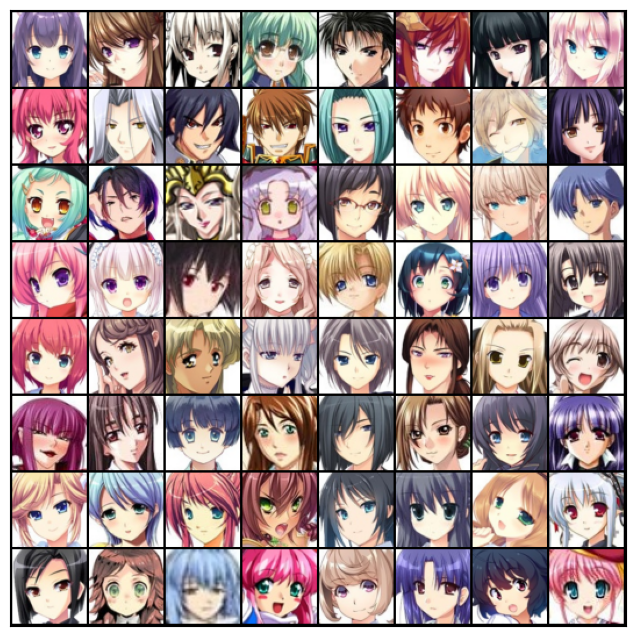

In [64]:
show_batch(train_dl)

In [65]:
!pip install jovian --upgrade --quiet

In [66]:
import jovian

In [67]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Using a GPU

We define two helper functions (`get_default_device} & `to_device}) and a helper class (`DeviceDataLoader}) to transport our model and data to the GPU, if one is available, so that we can use it easily.


In [68]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [69]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [70]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

Upon receiving an image as input, the discriminator attempts to categorise it as "generated" or "real". It is comparable to other neural networks in this regard. Convolutional neural networks (CNNs), which provide a single numerical output for each image, will be used. To gradually lower the size of the output feature map, we'll use a stride of 2.


![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [71]:
import torch.nn as nn

In [72]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

In [73]:
discriminator = to_device(discriminator, device)

## Generator Network

Usually, a vector or matrix of random integers (also called a latent tensor) is sent into the generator to serve as the seed for creating a picture. A latent tensor of shape {(128, 1, 1)} will be transformed into an image tensor of shape {3 x 28 x 28} by the generator. The {ConvTranspose2d} layer from PyTorch, which functions as a *transposed convolution* (also known as a *deconvolution*), will be used to do this.
 [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [74]:
latent_size = 128

In [75]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 3, 64, 64])


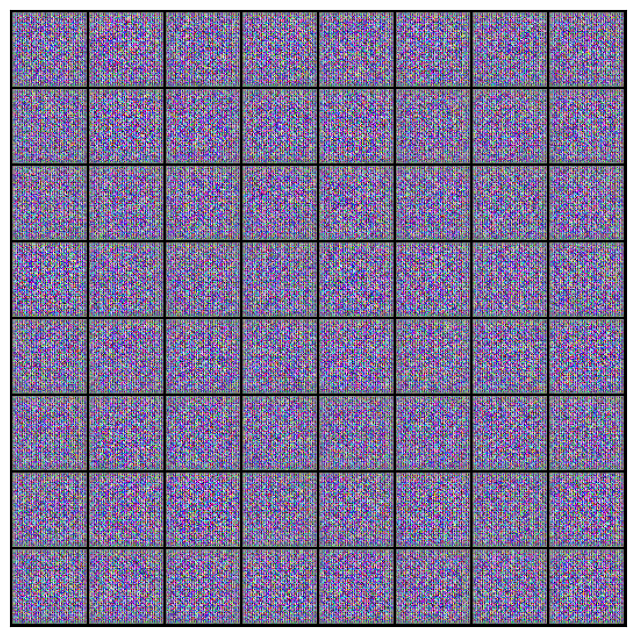

In [76]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet.

Let's move the generator to the chosen device.

In [77]:
generator = to_device(generator, device)

## Discriminator Training

We can measure the discriminator's ability to distinguish between genuine and produced images using the binary cross entropy loss function because it is a binary classification model.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [78]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.

- We first pass a batch of real images, and compute the loss, setting the target labels to 1.

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

How to train the generator is not immediately apparent, as the generator's outputs are images. Using the discriminator as a component of the loss function is a very clever method that we do here. It functions as follows:

Using the generator, we produce a batch of photos, which we then feed into the discriminantor.

Setting the target labels to 1, or real, allows us to compute the loss. The generator wants to "fool" the discriminator, which is why we take this action.

To "fool" the discriminator, we employ gradient descent, which involves adjusting the generator's weights to make it more adept at producing realistic images.

This appears in code as follows.


In [79]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [80]:
from torchvision.utils import save_image

In [81]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [82]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [83]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


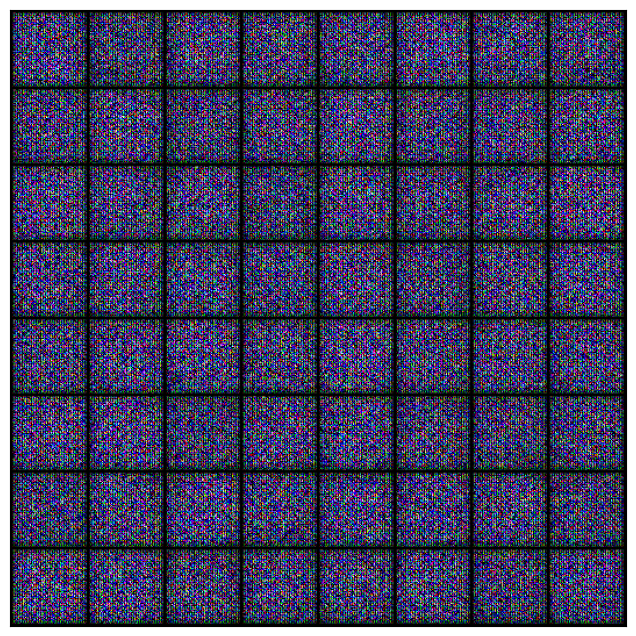

In [84]:
save_samples(0, fixed_latent)

In [85]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Full Training Loop

To train the discriminator and generator simultaneously for every batch of training data, let's define a `fit} function. Using some bespoke parameters (betas) that are known to perform well for GANs, we will employ the Adam optimizer. Additionally, we'll periodically store some sample-generated photos for review.


<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [86]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [87]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [88]:
lr = 0.0002
epochs = 25

In [89]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [90]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 8.4115, loss_d: 0.8806, real_score: 0.9132, fake_score: 0.5097
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.5348, loss_d: 0.4634, real_score: 0.8777, fake_score: 0.2578
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 2.5797, loss_d: 0.0688, real_score: 0.9737, fake_score: 0.0395
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 4.2937, loss_d: 0.1416, real_score: 0.9660, fake_score: 0.0942
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 6.4713, loss_d: 0.2732, real_score: 0.9731, fake_score: 0.1875
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.0160, loss_d: 0.1896, real_score: 0.8769, fake_score: 0.0289
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 5.5889, loss_d: 0.0959, real_score: 0.9450, fake_score: 0.0290
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.2201, loss_d: 0.4052, real_score: 0.7362, fake_score: 0.0111
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 6.5385, loss_d: 0.2596, real_score: 0.8112, fake_score: 0.0071
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 5.2440, loss_d: 0.1331, real_score: 0.9376, fake_score: 0.0595
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 4.3273, loss_d: 0.1626, real_score: 0.8955, fake_score: 0.0194
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 3.6031, loss_d: 0.5106, real_score: 0.6929, fake_score: 0.0058
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 5.3556, loss_d: 1.0243, real_score: 0.5237, fake_score: 0.0025
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 7.2814, loss_d: 0.2829, real_score: 0.9680, fake_score: 0.1811
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 4.3854, loss_d: 0.2048, real_score: 0.8558, fake_score: 0.0173
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 4.4510, loss_d: 0.1077, real_score: 0.9355, fake_score: 0.0319
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 6.5607, loss_d: 0.2939, real_score: 0.9670, fake_score: 0.2007
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 3.7217, loss_d: 0.1182, real_score: 0.9428, fake_score: 0.0515
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.3812, loss_d: 0.0775, real_score: 0.9728, fake_score: 0.0452
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 3.9498, loss_d: 0.1162, real_score: 0.9309, fake_score: 0.0370
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 4.4545, loss_d: 0.1181, real_score: 0.9595, fake_score: 0.0677
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 4.6161, loss_d: 0.2445, real_score: 0.9118, fake_score: 0.0998
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.3906, loss_d: 0.1416, real_score: 0.9490, fake_score: 0.0749
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 10.0637, loss_d: 2.6905, real_score: 0.9997, fake_score: 0.8507
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 4.3339, loss_d: 0.1269, real_score: 0.9276, fake_score: 0.0338
Saving generated-images-0025.png


In [91]:
losses_g, losses_d, real_scores, fake_scores = history

In [92]:
jovian.log_metrics(loss_g=losses_g[-1],
                   loss_d=losses_d[-1],
                   real_score=real_scores[-1],
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


Now that we have trained the models, we can save checkpoints.

In [93]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [94]:
from IPython.display import Image

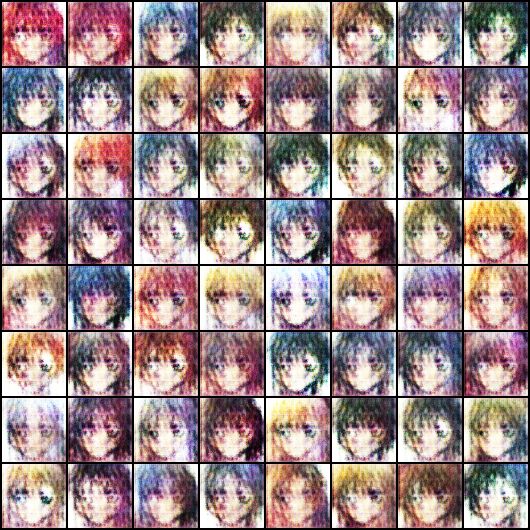

In [95]:
Image('./generated/generated-images-0001.png')

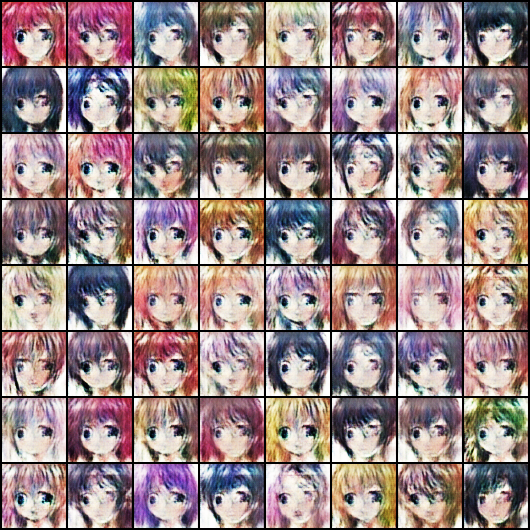

In [96]:
Image('./generated/generated-images-0005.png')

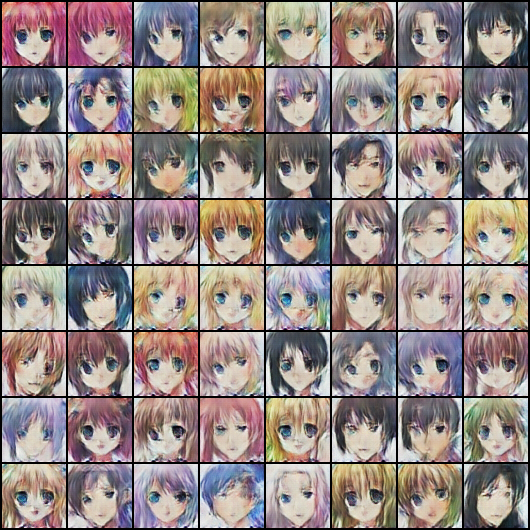

In [97]:
Image('./generated/generated-images-0010.png')

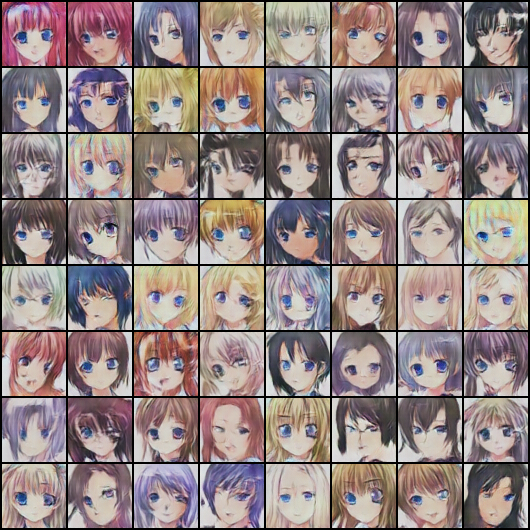

In [98]:
Image('./generated/generated-images-0020.png')

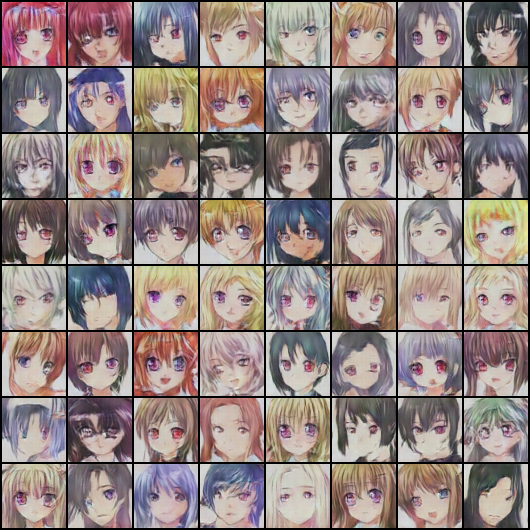

In [99]:
Image('./generated/generated-images-0025.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [100]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



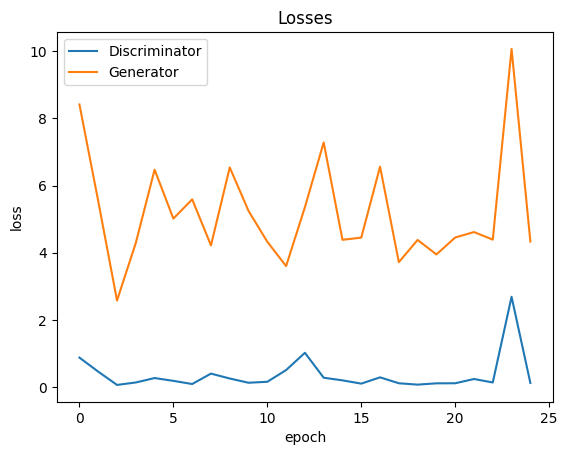

In [101]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

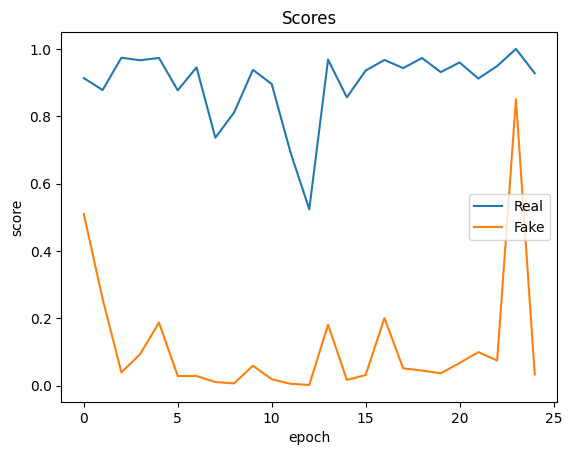

In [102]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Save and Commit

We are able to submit this experiment's complete snapshot to Jupiter:
- Jupyter nnotebook
- Metrics and hyperparameters
- Weights of models
- Instructional video


In [103]:
import jovian

In [104]:
jovian.commit(project=project_name,
              outputs=['G.pth', 'D.pth', 'gans_training.avi'],
              environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
